In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import Bunch

np.random.seed(0)

# ---- Neural Network Layers ----
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues, learning_rate):
        # Gradients for weights, biases, and inputs
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

        # Gradient descent parameter update
        self.weights -= learning_rate * self.dweights
        self.biases -= learning_rate * self.dbiases


# ---- Activtion Function ----
class Activation_RELU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0


class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-np.clip(inputs, -500, 500)))

    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))


# ---- Loss Calculation Function ----
class Loss:
    def calculate(self, output, y_true):
        sample_losses = self.forward(output, y_true)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        # Calculate the mean squared error
        sample_losses = (y_true - y_pred) ** 2
        return  np.mean(sample_losses, axis=-1)


    def backward(self, y_pred, y_true):
        # Number of samples
        samples = len(y_true)
        # Gradient with respect to predictions
        outputs = y_pred.shape[1]
        self.dinputs = -2 * (y_true - y_pred) / outputs
        self.dinputs = self.dinputs / samples

In [2]:
# 1. Load the dataset
cancer: Bunch = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names

# --- Split data into 50% train, 50% test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, shuffle=True
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (284, 30) (284,)
Test shape: (285, 30) (285,)


In [3]:
# 2. Select the top 2 features using mutual information
selector = SelectKBest(mutual_info_classif, k=2)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)  # use same features for test
selected_features = feature_names[selector.get_support()]

print("Top 2 Selected Features (Filter Method):")
print(selected_features)
print(X_train_new.shape, X_test_new.shape)

Top 2 Selected Features (Filter Method):
['worst perimeter' 'worst concave points']
(284, 2) (285, 2)


In [4]:
# 3. Layers of the nueral network model
layer1 = Layer_Dense(2,4)
activation1 = Activation_RELU()

layer2 = Layer_Dense(4,1)
activation2 = Activation_Sigmoid()

In [5]:
# 4. Calculate loss
loss_function = Loss_MeanSquaredError()

y_col1 = y_train.reshape(-1, 1)
y_plot1 = y_train.ravel()         # used for plotting (1D)
print(y_col1.shape)
y_col2 = y_test.reshape(-1, 1)
y_plot2 = y_test.ravel()
print(y_col2.shape)

(284, 1)
(285, 1)


In [6]:
# 5. Optimization and Back Propagation
lowest_loss = 9999999
best_layer1_weights = layer1.weights.copy()
fest_layer1_biases = layer1.biases.copy()
best_layer2_weights = layer2.weights.copy()
best_layer2_biases = layer2.biases.copy()

learning_rate = 0.01
epochs = 1000
loss_history = []

for iteration in range(epochs):
    # ---- Forward pass ----
    layer1.forward(X_train_new)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)

    # ---- Compute loss ----
    loss = loss_function.calculate(activation2.output, y_col1)
    loss_history.append(loss)  # <-- save loss per iteration

    # ---- Backward pass ----
    loss_function.backward(activation2.output, y_col1)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs, learning_rate)

    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs, learning_rate)

    # ---- Print progress ----
    if iteration % 100 == 0:
        print(f"Epoch {iteration}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.2500
Epoch 100, Loss: 0.2478
Epoch 200, Loss: 0.2459
Epoch 300, Loss: 0.2422
Epoch 400, Loss: 0.2391
Epoch 500, Loss: 0.2361
Epoch 600, Loss: 0.2332
Epoch 700, Loss: 0.2303
Epoch 800, Loss: 0.2275
Epoch 900, Loss: 0.2247


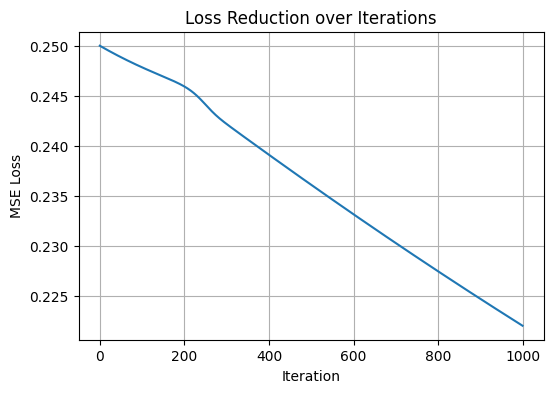

In [7]:
# 6. Plot loss over iterations
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title("Loss Reduction over Iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)

In [8]:
# 7. Plot decision boundary (Training)
# Create a grid covering the feature space
# -----------------------------
# Compute final training accuracy
# -----------------------------
layer1.forward(X_train_new)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

train_preds = (activation2.output > 0.5).astype(int)
train_accuracy = np.mean(train_preds == y_col1)
print(f"Final training accuracy: {train_accuracy*100:.2f}%")

# -----------------------------
# Compute final test accuracy
# -----------------------------
layer1.forward(X_test_new)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

test_preds = (activation2.output > 0.5).astype(int)
test_accuracy = np.mean(test_preds == y_col2)
print(f"Final test accuracy: {test_accuracy*100:.2f}%")

# -----------------------------
# Function to plot decision boundary
# -----------------------------
def plot_decision_boundary(X_data, y_labels, layer1, activation1, layer2, activation2, selected_features, title, accuracy):
    # Create meshgrid covering feature space
    x_min, x_max = X_data[:,0].min() - 1, X_data[:,0].max() + 1
    y_min, y_max = X_data[:,1].min() - 1, X_data[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Forward pass for grid points
    layer1.forward(grid_points)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    Z = (activation2.output > 0.5).astype(int).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, levels=[-0.1,0.5,1.1], cmap='RdBu', alpha=0.4)
    plt.scatter(X_data[:,0], X_data[:,1], c=y_labels, cmap='RdBu', edgecolors='k', s=40)
    plt.xlabel(selected_features[0])
    plt.ylabel(selected_features[1])
    plt.title(title)

    # Add legend with accuracy
    plt.scatter([], [], c='k', label=f"Accuracy: {accuracy*100:.2f}%")
    plt.legend()
    plt.show()

Final training accuracy: 90.49%
Final test accuracy: 92.98%


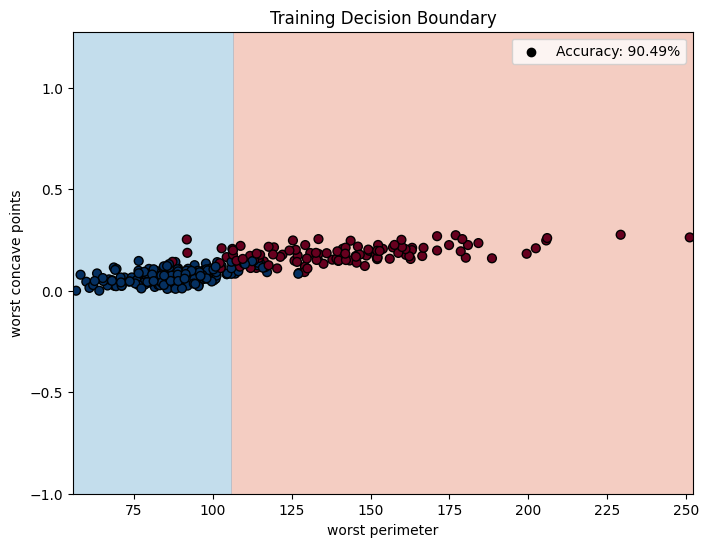

In [9]:
# -----------------------------
# Plot training decision boundary
# -----------------------------
plot_decision_boundary(X_train_new, y_train, layer1, activation1, layer2, activation2,
                       selected_features, "Training Decision Boundary", train_accuracy)

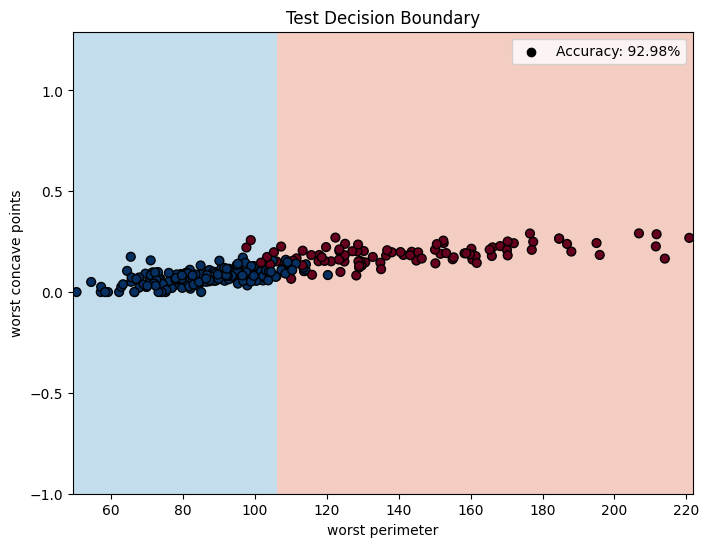

In [10]:
# -----------------------------
# Plot test decision boundary
# -----------------------------
plot_decision_boundary(X_test_new, y_test, layer1, activation1, layer2, activation2,
                       selected_features, "Test Decision Boundary", test_accuracy)